# Finding Lane Lines on the Road


***
The goals of this project is to make a pipeline that finds lane lines on the road. First, the pipeline is developed on individual images and fine tunned parameters. Later, it is improved by appling to a video stream with more stricky noise. The pipeline work well with stable videos. Potential shortcomings with proposed pipeline and possible improvements are also discussed.


## A. Propose Pipeline for Finding Lane Lines on the Road

In this project, first I use the tools in the lesson to develop pipeline to identify lane lines on the road in individual images. 

### A.1 Propose Pipeline for detecting lines from image
0. Read in an image
1. Select lane colors only 
2. Convert input image to grayscale
3. Apply a Gausian noise kernel filter to blur the grayscale image
4. Use Canny edge detection to detect edges from the blurred image
5. Select region of interest on the edge image for further processing
6. Use Hough transformation to detect lines from masked image
7. Draw the lines on the original image 

### Import packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pdb
import os

### Helper Functions

Below are some helper functions to help provided from the course.

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """    
    for line in lines: 
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)      
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)
    

#### 1. Read in an Image
Firstly, I loaded the image and studied the its dimension as well as specification

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


([], <a list of 0 Text yticklabel objects>)

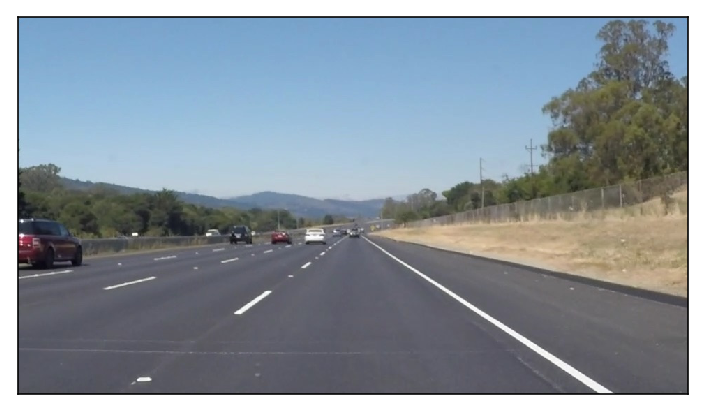

In [3]:
# 1. Read in an image
files = os.listdir("test_images/")
image = mpimg.imread('test_images/' + files[1])

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.figure()
plt.imshow(image)
plt.xticks([])
plt.yticks([])

#### 2. Select lane colors
Since the lane colors are white and yellow, I do the color selection for white and yellow colors only. At the beginning, I apply the color selection in the RGB space, with the thresholds for white and yellow colors as below.

([], <a list of 0 Text yticklabel objects>)

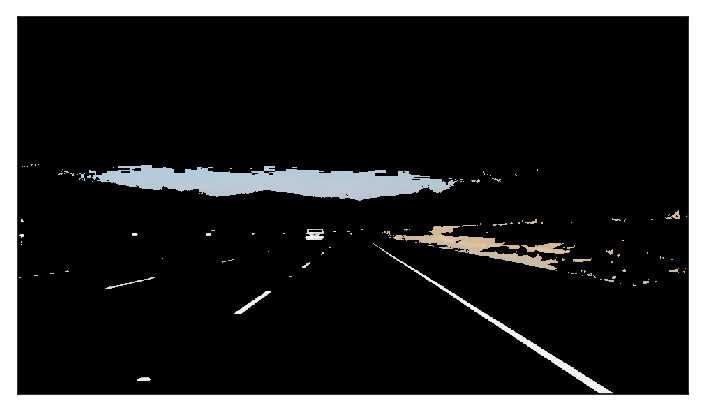

In [4]:
def filter_white_yellow(image):
    """
    Applies a color selection, select only white and yellow colors.
    
    Only keeps white and yellow colors. The rest of the image is set to black.
    """
    # white color mask
    lower = np.uint8([190, 190, 190])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([180, 180, 0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

# 2. Select lane colors only
white_yellow = filter_white_yellow(image)
plt.figure()
plt.imshow(white_yellow, cmap=None)
plt.xticks([])
plt.yticks([])

This filter function work well with testing images. 

#### 3. Convert to grayscale
Convert the color selected image to grayscale for further processing using the grayscale function.

([], <a list of 0 Text yticklabel objects>)

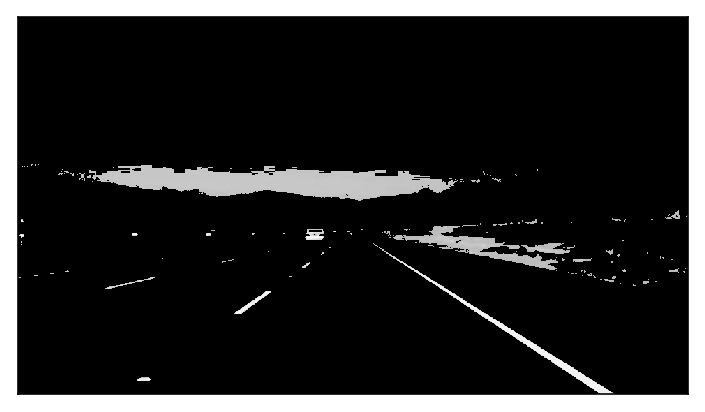

In [5]:
# 3. Convert input image to grayscale
gray = grayscale(white_yellow)
plt.figure()
plt.imshow(gray, cmap='gray')
plt.xticks([])
plt.yticks([])

#### 4. Apply a Gausian noise kernel filter to blur the grayscale image
Preprocess the grayscale image by applying a Gausian noise kernel filter before doing the edge detection.

In [6]:
# 4. Apply a Gausian noise kernel filter to blur the grayscale image
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)

#### 5. Use Canny edge detection to detect edges from the blurred image
Apply Canny edge detection algorithm to the grayscle image and get another image called edges. Fine tunes the low_threshold and high_threshold for good edge detection.

The algorithm will first detect strong edge (strong gradient) pixels above the high_threshold, and reject pixels below the low_threshold. Next, pixels with values between the low_threshold and high_threshold will be included as long as they are connected to strong edges. The output edges is a binary image with white pixels tracing out the detected edges and black everywhere else. Canny recommended a high_threshold:low_threshold ratio between 2:1 and 3:1.

([], <a list of 0 Text yticklabel objects>)

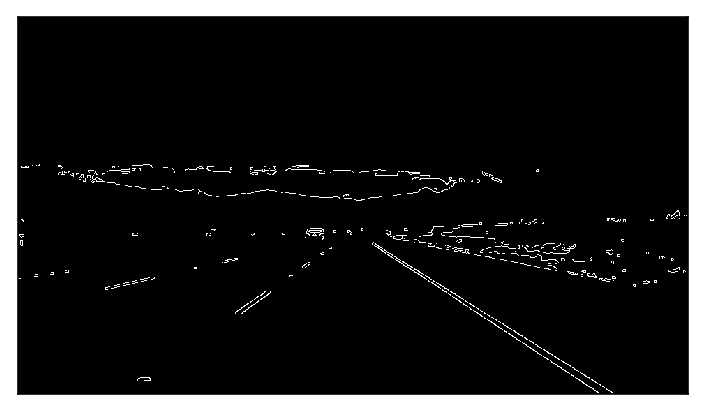

In [7]:
# 5. Use Canny edge detection to detect edges from the blurred image
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)
plt.figure()
plt.imshow(edges, cmap='gray')
plt.xticks([])
plt.yticks([])

#### 6. Select region of interest on the edge image for further processing
Since I just want to detect the lane lines, so I consider only the region in front of the facing camera which contains the left and right lanes. 

In this case, I keep the same assumption that the front facing camera that took the image is mounted in a fixed position on the car, such that the lane lines will always appear in the same general region of the image. 

The variable vertices of a quadrilateral region is used to retain for my color selection, while masking everything else out. 

([], <a list of 0 Text yticklabel objects>)

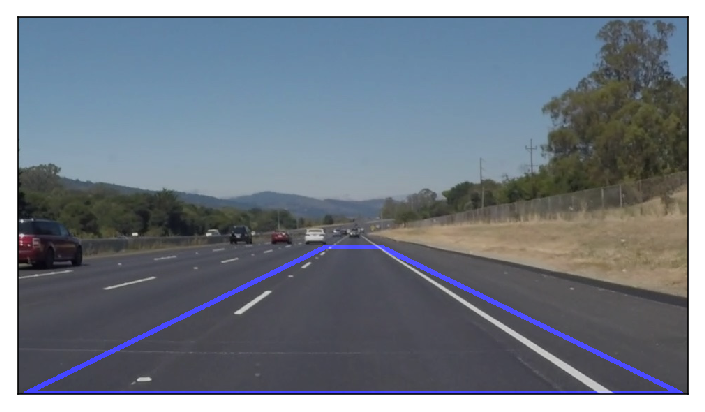

In [8]:
# 6. Select region of interest on the edge image for further processing
vertices = np.array([[(10,image.shape[0]-1),(image.shape[1]/2 - 40, image.shape[0]*0.61), (image.shape[1]/2 + 40, image.shape[0]*0.61), (image.shape[1]-10,image.shape[0]-1)]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
# Plot region for tuning parameters
region = np.copy(image)*0 
for i in range(0,3):
    cv2.line(region,tuple(vertices[0][i]),tuple(vertices[0][i+1]),(0,0,255),5) #draw lines with blue and size = 10
cv2.line(region,tuple(vertices[0][3]),tuple(vertices[0][0]),(0,0,255),5)
region_image = weighted_img(region, image, α=0.8, β=1., λ=0.)
plt.figure()
plt.imshow(region_image)
plt.xticks([])
plt.yticks([])

#### 7. Use Hough transformation to detect lines from masked image
I'm using cv2.HoughLinesP to detect lines in the edge image, fine tuning Hough transformation paramters and draw the lines using draw_lines().

There are several Hough transformation parameters that needed to tweak and tune:

+ rho – Distance resolution of the accumulator in pixels.
+ theta – Angle resolution of the accumulator in radians.
+ threshold – Accumulator threshold parameter. Only those lines are returned that get enough votes (> threshold).
+ minLineLength – Minimum line length. Line segments shorter than that are rejected.
+ maxLineGap – Maximum allowed gap between points on the same line to link them.

#### 8. Draw the lines on the original image
After having the lines image from Hough transformation, I draw the lines on the original image.

([], <a list of 0 Text yticklabel objects>)

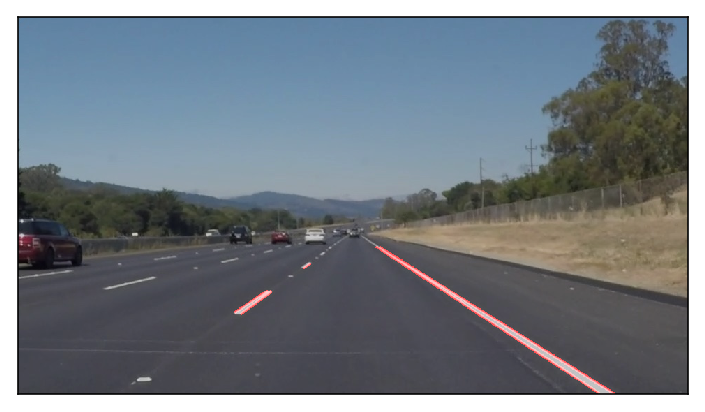

In [9]:
# 7. Use Hough transformation to detect lines from masked image
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 25     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 5 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments
lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
# 8. Draw the lines on the original image
lines_image = weighted_img(lines, image, α=0.8, β=1., λ=0.)
plt.figure()
plt.imshow(lines_image)
plt.xticks([])
plt.yticks([])

The whole code for detecting lane road on individual images pipeline as below.

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


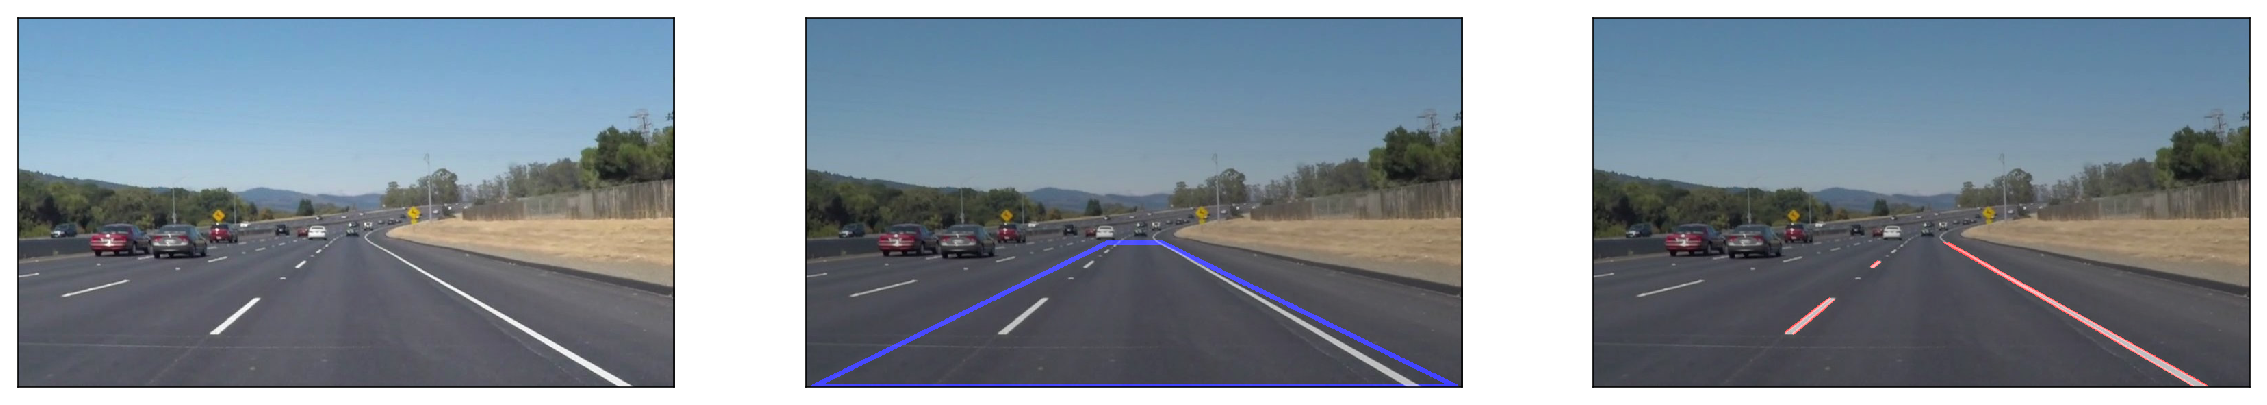

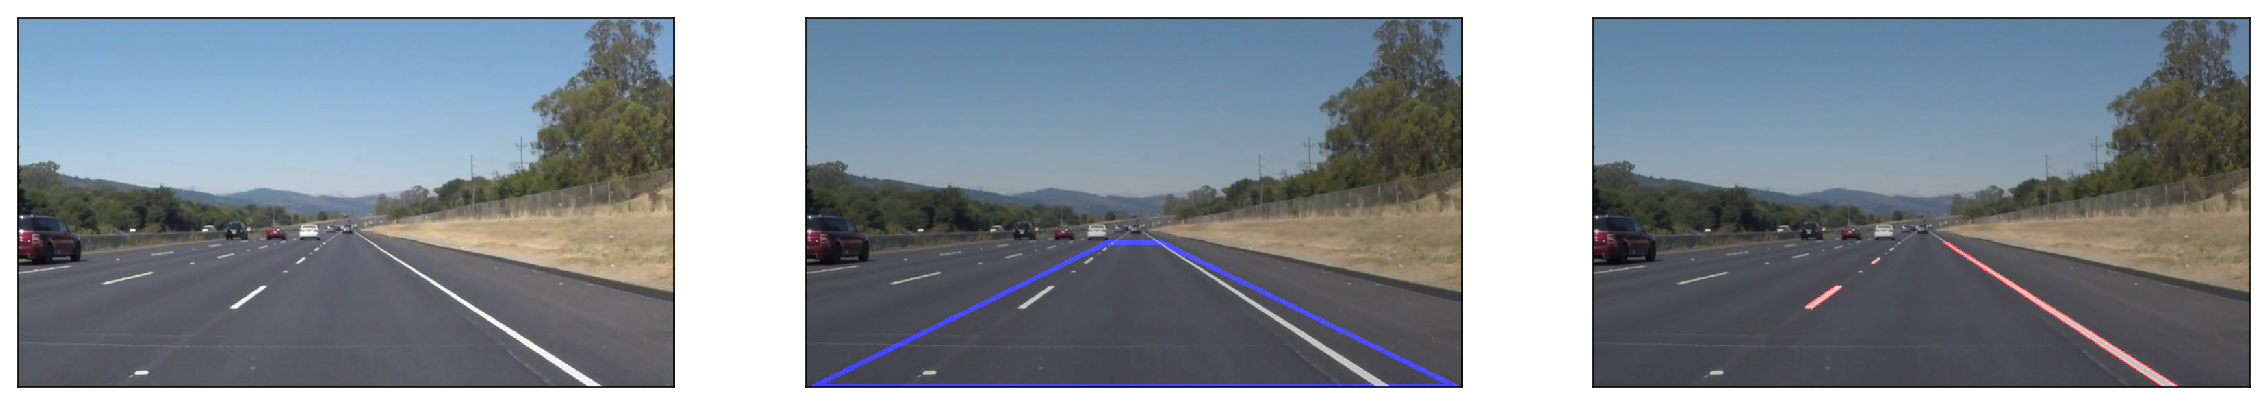

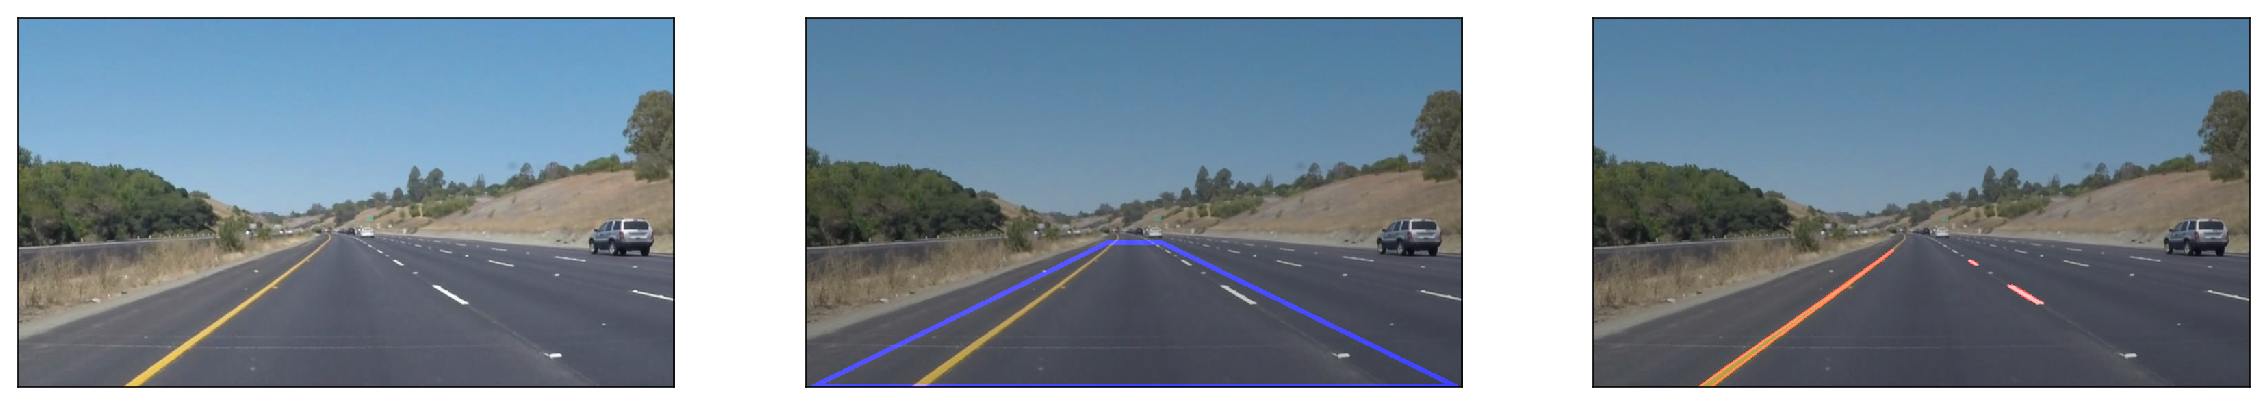

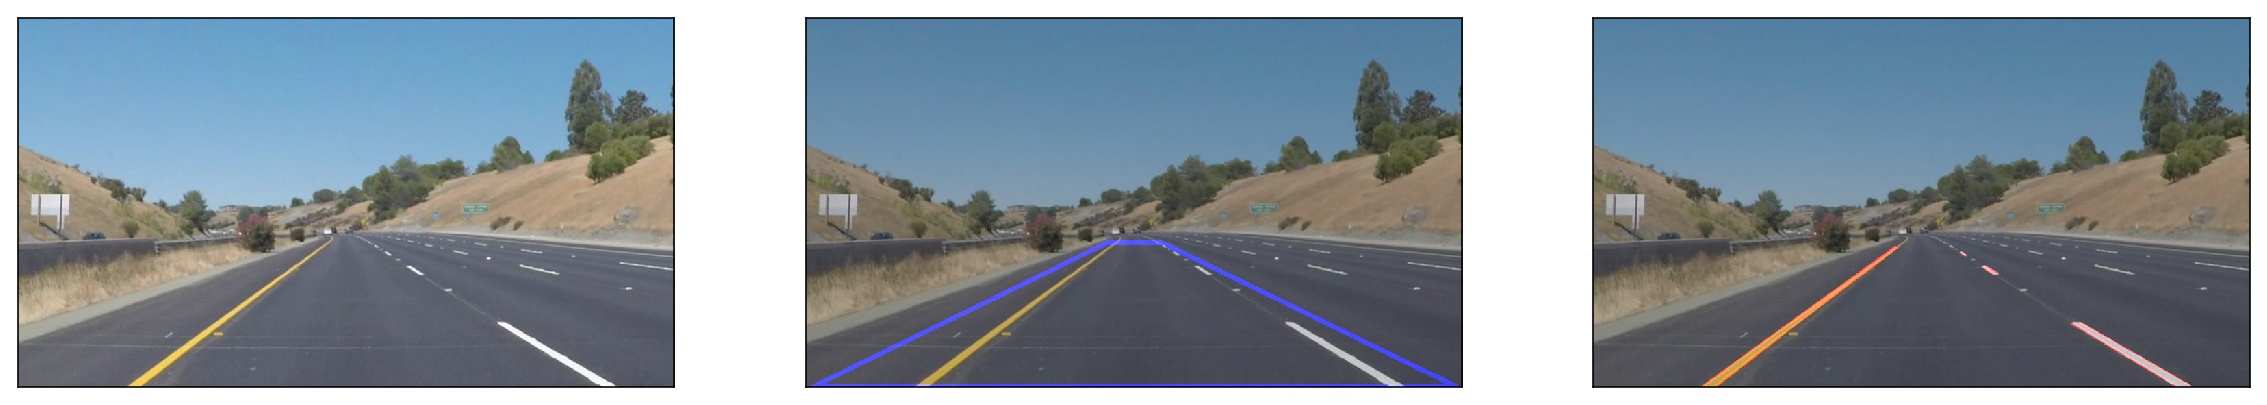

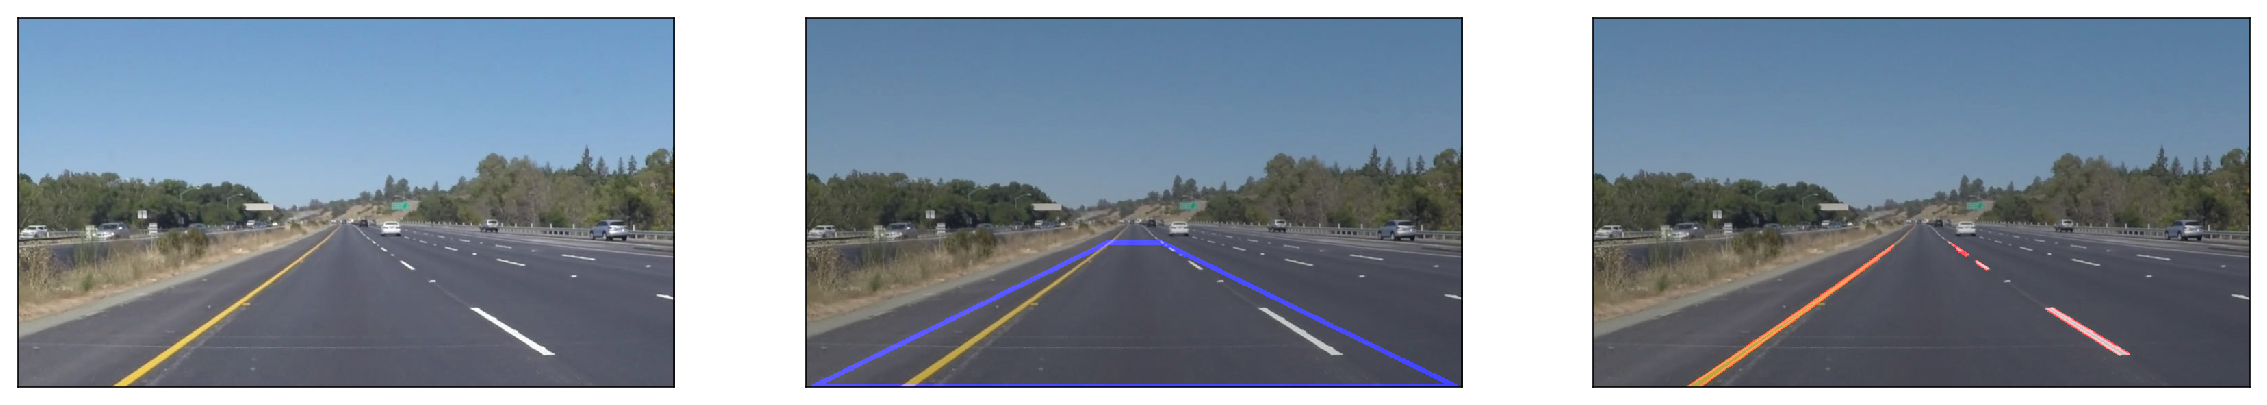

In [10]:
for i in range(0,5):
# 1. Read in an image
    files = os.listdir("test_images/")
    image = mpimg.imread('test_images/' + files[i])

    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # 2. Select lane colors only
    white_yellow = filter_white_yellow(image)

    # 3. Convert input image to grayscale
    gray = grayscale(white_yellow)

    # 4. Apply a Gausian noise kernel filter to blur the grayscale image
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # 5. Use Canny edge detection to detect edges from the blurred image
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # 6. Select region of interest on the edge image for further processing
    vertices = np.array([[(10,image.shape[0]-1),(image.shape[1]/2 - 40, image.shape[0]*0.61), (image.shape[1]/2 + 40, image.shape[0]*0.61), (image.shape[1]-10,image.shape[0]-1)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    # Plot region for tuning parameters
    region = np.copy(image)*0 
    for i in range(0,3):
        cv2.line(region,tuple(vertices[0][i]),tuple(vertices[0][i+1]),(0,0,255),5) #draw lines with blue and size = 10
    cv2.line(region,tuple(vertices[0][3]),tuple(vertices[0][0]),(0,0,255),5)
    region_image = weighted_img(region, image, α=0.8, β=1., λ=0.)
    plt.subplot(1,3,2)
    plt.imshow(region_image)
    plt.xticks([])
    plt.yticks([])

    # 7. Use Hough transformation to detect lines from masked image
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 25     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 5 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    # 8. Draw the lines on the original image
    lines_image = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    plt.subplot(1,3,3)
    plt.imshow(lines_image)
    plt.xticks([])
    plt.yticks([])

### A.2 Test on Videos

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
import imageio
imageio.plugins.ffmpeg.download()

In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    # 1. Select lane colors only
    white_yellow = filter_white_yellow(image)

    # 2. Convert input image to grayscale
    gray = grayscale(white_yellow)

    # 3. Apply a Gausian noise kernel filter to blur the grayscale image
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # 4. Use Canny edge detection to detect edges from the blurred image
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # 5. Select region of interest on the edge image for further processing
    vertices = np.array([[(10,image.shape[0]-1),(image.shape[1]/2 - 40, image.shape[0]*0.61), (image.shape[1]/2 + 40, image.shape[0]*0.61), (image.shape[1]-10,image.shape[0]-1)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)          

    # 6. Use Hough transformation to detect lines from masked image
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 25     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 5 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    # 7. Draw the lines on the original image
    lines_image = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    
    return lines_image

Let's try the one with the solid white lane on the right first ...

In [14]:
white_output = 'test_videos_output/solidWhiteRight_1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_1.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_1.mp4


100%|█████████▉| 221/222 [00:03<00:00, 55.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_1.mp4 

CPU times: user 3.11 s, sys: 1.13 s, total: 4.24 s
Wall time: 4.53 s


Play the video inline

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### A.3 Improve the draw_lines() function

#### Modify the draw_lines() and hough_lines() to get single line lanes
After get the lane lines successfully, I modify the draw_lines() to average/extrapolate the line segments I detect to map out the full extent of the lane.  

First, I separate the lines to the left and the right lines by calculating their slopes and intercepts to decide which segments are part of the left lane vs. the right lane. Only slopes and intercepts of lines which in the slope threshold are kept. Here, I select the upper bound slope for the lane lines is 80 degree and lower bound slope is 20 degree. This slope thresholds help the detecting method robust to noise, which are unwanted nearly horizonal and vertical lines. Then, I average the position (slope and intercept) of each of the lines and extrapolate to the top and bottom of the lane. The vertices parameter is added to above function to get the top and bottom position of the region of interest. I also adjust the thickness parameter to 10 for better observation.

hough_lines() and process_image() are also added vertices parameter for updating the modifications

In [16]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10, vertices = np.array([[(10,539),(440, 330), (520, 330), (950,539)]], dtype=np.int32)):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Adjust the draw line function: average the position of each of the lines 
    # and extrapolate to the top and bottom of the lane
    # First, average the slope and intercept of lines 
    right_slope   = [] 
    right_intercept = [] 
    left_slope   = [] 
    left_intercept = []     
    for line in lines: 
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)   
            # Calculate the slope and intercept of the line
            slope = float((y2-y1)/(x2-x1))
            intercept = y1 - slope * x1
            # Separating line segments by their slope, removing nearly horizontal lines with slope_threshold_low and 
            # nearly vertical lines with slope_threshold_high
            slope_threshold_low = 20.0 * np.pi/180.0
            slope_threshold_high = 80.0 * np.pi/180.0 
            if not (np.isnan(slope) or np.isinf(slope)):
                if slope < -slope_threshold_low and slope > -slope_threshold_high: # negative, belong to right lane line
                    right_slope.append(slope)
                    right_intercept.append(intercept)
                if slope > slope_threshold_low and slope < slope_threshold_high: # positive, belong to left lane line
                    left_slope.append(slope)
                    left_intercept.append(intercept)
    right_slope_avg = np.mean(right_slope)
    right_intercept_avg = np.mean(right_intercept)
    left_slope_avg = np.mean(left_slope)
    left_intercept_avg = np.mean(left_intercept)
    
    # Then, extrapolate to the top and bottom of the lane
    if not (np.isnan(right_intercept_avg) or np.isnan(right_slope_avg)):
        # right bottom 
        right_lane_y1 = vertices[0][3][1]
        # print(right_lane_y1,right_intercept_avg,right_slope_avg)
        right_lane_x1 = int((right_lane_y1 - right_intercept_avg) / right_slope_avg)
        # right top
        right_lane_y2 = vertices[0][2][1]
        right_lane_x2 = int((right_lane_y2 - right_intercept_avg) / right_slope_avg)
        # left bottom
        left_lane_y1 = vertices[0][0][1]
        left_lane_x1 = int((left_lane_y1 - left_intercept_avg) / left_slope_avg)
        # right top
        left_lane_y2 = vertices[0][1][1]
        left_lane_x2 = int((left_lane_y2 - left_intercept_avg) / left_slope_avg)  
        # Draw the lanes
        cv2.line(img, (right_lane_x1, right_lane_y1), (right_lane_x2, right_lane_y2), color, thickness) 
        cv2.line(img, (left_lane_x1, left_lane_y1), (left_lane_x2, left_lane_y2), color, thickness) 
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, vertices):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, vertices=vertices)
    return line_img

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    # 1. Select lane colors only
    white_yellow = filter_white_yellow(image)

    # 2. Convert input image to grayscale
    gray = grayscale(white_yellow)

    # 3. Apply a Gausian noise kernel filter to blur the grayscale image
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # 4. Use Canny edge detection to detect edges from the blurred image
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # 5. Select region of interest on the edge image for further processing
    vertices = np.array([[(10,image.shape[0]-1),(image.shape[1]/2 - 40, image.shape[0]*0.61), (image.shape[1]/2 + 40, image.shape[0]*0.61), (image.shape[1]-10,image.shape[0]-1)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)          

    # 6. Use Hough transformation to detect lines from masked image
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 25     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 5 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap, vertices)

    # 7. Draw the lines on the original image
    lines_image = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    
    return lines_image

Let's try the one with the solid white lane on the right video again

In [17]:
white_output = 'test_videos_output/solidWhiteRight_2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_2.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_2.mp4


100%|█████████▉| 221/222 [00:04<00:00, 46.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_2.mp4 

CPU times: user 3.45 s, sys: 1.12 s, total: 4.56 s
Wall time: 5.38 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. 

In [19]:
yellow_output = 'test_videos_output/solidYellowLeft_2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_2.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_2.mp4


100%|█████████▉| 681/682 [00:14<00:00, 48.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_2.mp4 

CPU times: user 10.5 s, sys: 3.45 s, total: 14 s
Wall time: 14.6 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

Try the optional challenge video

In [21]:
challenge_output = 'test_videos_output/challenge_2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_2.mp4
[MoviePy] Writing video test_videos_output/challenge_2.mp4


100%|██████████| 251/251 [00:10<00:00, 25.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_2.mp4 

CPU times: user 6.64 s, sys: 2.79 s, total: 9.44 s
Wall time: 13.3 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

There are some frames where the yellow lane detection is off due to the lane shadow on the road or the trees dark shadow. I modify the filter_white_yellow() by changing the rgb color space to hls color space to better constrast between the lanes and shadows. 

In [23]:
def filter_white_yellow(image):
    """
    Applies a color selection, select only white and yellow colors.
    
    Only keeps white and yellow colors. The rest of the image is set to black.
    """
    # change to hls color space for better color selection due to light conditions and noise
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # white color mask
    lower = np.uint8([0, 200, 0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(hls_image, lower, upper)
    # yellow color mask
    lower = np.uint8([10, 0, 100])
    upper = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(hls_image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

#### Now try the videos again

In [24]:
white_output = 'test_videos_output/solidWhiteRight_3.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_3.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_3.mp4


100%|█████████▉| 221/222 [00:04<00:00, 46.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_3.mp4 

CPU times: user 5.23 s, sys: 1.82 s, total: 7.04 s
Wall time: 5.05 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [26]:
yellow_output = 'test_videos_output/solidYellowLeft_3.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_3.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_3.mp4


100%|█████████▉| 681/682 [01:15<00:00,  8.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_3.mp4 

CPU times: user 15.6 s, sys: 5.21 s, total: 20.8 s
Wall time: 1min 16s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [28]:
challenge_output = 'test_videos_output/challenge_3.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_3.mp4
[MoviePy] Writing video test_videos_output/challenge_3.mp4


100%|██████████| 251/251 [00:10<00:00, 22.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_3.mp4 

CPU times: user 9.74 s, sys: 2.8 s, total: 12.5 s
Wall time: 12 s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## B. Potential shortcomings

The pipeline works quite well for testing images and videos since parameters are fine tunned for specific videos. However, if there are different noise types, for example: lines detected from near running cars, some obstacles on the road has white or yellow color, there are different color lanes or there is fading color lines on the road, etc., the proposed method may not be robust to noise any more and could cause the missing detection.
Another shortcomming of the pipeline may be from the region of interest which may not sufficient for different types of lanes or different mounting positions/angles, such as wider/narrower lanes, longer/shorter lanes,.

## C. Possible improvements

One possible improvement is in the color selection by adding more color mask for different lane color such as red lane. Another possible improvement is in the region of interest by define flexible region of interest that fit for different kinds of lanes. In addition, we can add feedback channel in controlling average lane slope and intercept through multiple frames for smoothier lane detection. Fine tunning parameters steps can be done automatically by machining learning algorithms and grid search. 